# Introduction
This code reimplements the project Single-Pathway DeepMedic. You can use this code to learn 3D medical image segemntation.

It is a basic CNN network from DeepMedic to segment brain tumor, but we use dilation convolution in some layers. The traing process uses $75*75*75$ images to get $47*47*47$ prediction. However, we use full size image to test the model and get DICE score and save the segmentation results. You can use 3D slicer to visualize the .mha and .nii file. The DICE score is not good enough, you can change hyperparameters such as learning rate and batch size to improve the DICE score in the training process, even you can change the testing program for better performance and we believe that it will help.

This code needs about 8GB GPU memory. If you don't have enough memory, you can reduce the crop size and batch size, even you can use [Google Colab](https://colab.research.google.com/) for free GPU just requiring minor changes. 


In [0]:
!cd drive&&ls

'Colab Notebooks'   __MACOSX			      Untitled0.ipynb
 dataset.zip	    Single_Pathway_DeepMedic-master
 HGG		    Untitled


In [0]:
!pip install SimpleITK
!pip install nibabel==2.3.3
!pip install numpy
!pip3 install torch torchvision
!wget http://cseweb.ucsd.edu/~yaq007/dataset.zip
!unzip dataset.zip
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive


--2019-11-13 23:41:15--  http://cseweb.ucsd.edu/~yaq007/dataset.zip
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 825764588 (788M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 787.51M  11.3MB/s    in 65s     

2019-11-13 23:42:21 (12.1 MB/s) - ‘dataset.zip’ saved [825764588/825764588]

/bin/bash: uzip: command not found


Archive:  dataset.zip
   creating: HGG/
  inflating: HGG/.DS_Store           
   creating: __MACOSX/
   creating: __MACOSX/HGG/
  inflating: __MACOSX/HGG/._.DS_Store  
   creating: HGG/brats_2013_pat0001_1/
  inflating: HGG/brats_2013_pat0001_1/.DS_Store  
   creating: __MACOSX/HGG/brats_2013_pat0001_1/
  inflating: __MACOSX/HGG/brats_2013_pat0001_1/._.DS_Store  
   creating: HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/
   creating: HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.nii/
  inflating: HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.nii/mask.nii.gz  
   creating: __MACOSX/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/
   creating: __MACOSX/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.nii/
  inflating: __MACOSX/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.nii/._mask.nii.gz  
  inflating: __MACOSX/HGG/bra

# Requirements
Pytorch 1.0 

Nibabel   

SimpleITK


# Data
You can download the dataset from http://cseweb.ucsd.edu/~yaq007/dataset.zip,  which is subset of [BraTs 2015](https://www.smir.ch/BRATS/Start2015), and this subset have 20 brain turmor subjects for training and 54 subjects for testing which include four moldalities: FLAIR, T1, T1c, T2, and mask and ground truth. The ground truth of patient images have four different labels:

* label 1: necrosis
* label 2: edema
* label 3: non-enhancing tumor
* label 4: enhancing tumor
* label 0: everything else

The evaluation is done for 3 different tumor sub-compartements:
* Whole tumor: label 1, 2, 3, 4
* Enhance tumor: label 4
* Tumor core: 1, 3, 4

# Trained Models
You can download the the trained models from [here](http://cseweb.ucsd.edu/~yaq007/models.tar.gz)(the Basic models corespond to our project), which is from the project [Autofocus Layer for Semantic Segmentation](https://github.com/yaq007/Autofocus-Layer).

In [0]:

import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import os
import nibabel as nib
import argparse
# from distutils.version import LooseVersion
import math
import SimpleITK as sitk


from torch.utils.data import Dataset
import numpy as np
import random
import nibabel as nib

class TrainDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.num_input = 5
        self.length = int(len(self.root_dir)/self.num_input)
        self.crop_size = [75,75,75]
        self.random_flip = True
        # this path is the data directory, you can change it for your need.
        self.root_path = ''
        # assert args.mask, "Missing mask as the input"
        # assert args.normalization, "You need to do the data normalization before training"
    
    def __len__(self):
        return self.length
   
    def __getitem__(self, idx):
        im = []
        for i in range(self.num_input):
            direct, _ = self.root_dir[self.num_input * idx + i].split("\n")
            if i < self.num_input - 1:
                image = nib.load(self.root_path + direct + '.gz').get_data()
                image = np.expand_dims(image, axis=0)
                im.append(image)
                if i == 0:
                    mask = nib.load(self.root_path + direct + "/mask.nii.gz").get_data()
            else:
                labels = nib.load(self.root_path + direct + '.gz').get_data()
        
        images = np.concatenate(im, axis=0).astype(float)
        
        # images shape: 4 x H x W x D 
        # labels shape: H x W x D 
        sample = {'images': images, 'mask': mask, 'labels':labels}
        transform = RandomCrop(self.crop_size, self.random_flip, self.num_input)
        sample = transform(sample)
        return sample

class ValDataset(Dataset):
    def __init__(self, image, label, mask, num_segments, idz):
        self.images = image
        self.labels = label
        self.mask = mask
        self.numx = num_segments[0]
        self.numy = num_segments[1]
        self.idz = idz
        self.center_size = [47,47,47]
        self.crop_size = [75,75,75]
        self.num_input = 5
        
    def __len__(self):
        return self.numy
   
    def __getitem__(self, idy):
        h, w, d = self.crop_size
        left =  np.arange(self.numx) * self.center_size[0]
        bottom =  idy * self.center_size[1]
        forward = self.idz * self.center_size[2]
             
        image = np.zeros([self.numx, self.num_input, h, w, d])
        mask = np.zeros([self. numx, h, w, d])
        label = np.zeros([self.numx, h, w, d])
        
        # dimension of label and image B x H x W x D 
        for i in range(self.numx):
            image[i,:] = self.images[:, left[i]: left[i] + h, bottom : bottom + w, forward : forward + d]
            label[i,:] = self.labels[left[i]: left[i] + h, bottom : bottom + w, forward : forward + d]
            mask[i,:] = self.mask[left[i]: left[i] + h, bottom : bottom + w, forward : forward + d]
            
        # images shape: H x W x D 
        # labels shape: H x W x D 
        sample = {'images': image, 'labels':label, 'mask':mask}
        return sample

class ValDataset_full(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.num_input = 5
        self.length = int(len(self.root_dir)/self.num_input)
        self.root_path = ''
        # assert args.mask, "Missing mask as the input"
        # assert args.normalization, "You need to do the data normalization before training"
    
    def __len__(self):
        return self.length
   
    def __getitem__(self, idx):
        im = []
        for i in range(self.num_input):
            direct, _ = self.root_dir[self.num_input * idx + i].split("\n")
            name = direct
            if i < self.num_input - 1:
                image = nib.load(self.root_path + direct + '.gz').get_data()
                image = np.expand_dims(image, axis=0)
                im.append(image)
                if i == 0:
                    mask = nib.load(self.root_path + direct + "/mask.nii.gz").get_data()
            else:
                labels = nib.load(self.root_path + direct + '.gz').get_data()
        
        images = np.concatenate(im, axis=0).astype(float)
        
        # images shape: 4 x H x W x D 
        # labels shape: H x W x D 
        sample = {'images': images, 'mask': mask, 'labels':labels, 'name': name}
        return sample

class TestDataset(Dataset):
    def __init__(self, image, mask, num_segments, idz):
        self.images = image
        self.mask = mask
        self.numx = num_segments[0]
        self.numy = num_segments[1]
        self.idz = idz
        self.center_size = [47,47,47]
        self.crop_size = [75,75,75]
        self.num_input = 5
        
    def __len__(self):
        return self.numy
   
    def __getitem__(self, idy):
        h, w, d = self.crop_size
        left =  np.arange(self.numx) * self.center_size[0]
        bottom =  idy * self.center_size[1]
        forward = self.idz * self.center_size[2]
             
        image = np.zeros([self.numx, self.num_input, h, w, d])
        mask = np.zeros([self. numx, h, w, d])
        
        # dimension of label and image B x H x W x D 
        for i in range(self.numx):
            image[i,:] = self.images[:, left[i]: left[i] + h, bottom : bottom + w, forward : forward + d]
            mask[i,:] = self.mask[left[i]: left[i] + h, bottom : bottom + w, forward : forward + d]
            
        # images shape: H x W x D 
        # labels shape: H x W x D 
        sample = {'images': image, 'mask':mask}
        return sample   

class RandomCrop(object):
    def __init__(self, output_size, random_flip, num_input):
        assert len(output_size) == 3
        self.output_size = output_size        
        self.random_flip = random_flip
        self.num_input = num_input
    
    def __call__(self, sample):
        images, labels, mask = sample['images'], sample['labels'], sample['mask']   
        h, w, d = self.output_size
       
        # generate the training batch with equal probability for the foreground and background
        # within the mask
        labelm = labels + mask
        # choose foreground or background
        fb = np.random.choice(2)
        if fb:
            index = np.argwhere(labelm > 1)
        else:
            index = np.argwhere(labelm == 1)
        # choose the center position of the image segments
        choose = random.sample(range(0, len(index)), 1)
        center = index[choose].astype(int)
        center = center[0]
        
        # check whether the left and right index overflow
        left = []
        for i in range(3):
        	margin_left = int(self.output_size[i]/2)
        	margin_right = self.output_size[i] - margin_left
        	left_index = center[i] - margin_left
        	right_index = center[i] + margin_right
        	if left_index < 0:
        		left_index = 0
        	if right_index > labels.shape[i]:
        		left_index = left_index - (right_index - labels.shape[i])
        	left.append(left_index)
        	
        # crop the image and the label to generate image segments
        image = np.zeros([self.num_input - 1, h, w, d])
        label = np.zeros([h, w, d])
        
        image = images[:, left[0]:left[0] + h, left[1]:left[1] + w, left[2]:left[2] + d]
        label = labels[left[0]:left[0] + h, left[1]:left[1] + w, left[2]:left[2] + d]        
        
        # random flip 
        if self.random_flip:       
        	flip = np.random.choice(2)*2-1
        	image = image[:,::flip,:,:]
        	label = label[::flip,:,:]

        return {'images':image.copy(), 'labels': label.copy()}

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count  

# Define the network 
This network is Single-Pathway Deepmedic, you can check this [paper](https://www.sciencedirect.com/science/article/pii/S1361841516301839) for further research.

In [0]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes1, outplanes1, outplanes2, kernel=3, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 =nn.Conv3d(inplanes1, outplanes1, kernel_size=kernel,dilation=2)
        self.bn1 = nn.BatchNorm3d(outplanes1)
        self.conv2 =nn.Conv3d(outplanes1, outplanes2, kernel_size=kernel, dilation=2)
        self.bn2 = nn.BatchNorm3d(outplanes2)
        self.relu = nn.ReLU(inplace=True)
        if inplanes1==outplanes2:            
            self.downsample = downsample
        else:
            self.downsample = nn.Sequential(nn.Conv3d(inplanes1, outplanes2, kernel_size=1), nn.BatchNorm3d(outplanes2))
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def forward(self,x):
        residual = x[:,:, 4:-4, 4:-4, 4:-4]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
    
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            residual = self.downsample(residual)
        
        x += residual
        x = self.relu(x)
        return x
    
    
    
    
class Basic(nn.Module):
    def __init__(self, channels, kernel_size):
        super(Basic, self).__init__()
        
        # parameters in the architecture

        
        self.channels = channels     
        self.kernel_size = kernel_size
        
        # network architecture
        self.conv1 = nn.Conv3d(self.channels[0], self.channels[1], kernel_size=self.kernel_size)
        self.bn1 = nn.BatchNorm3d(self.channels[1])
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(self.channels[1], self.channels[2], kernel_size=self.kernel_size)
        self.bn2 = nn.BatchNorm3d(self.channels[2])
        
        self.layer3 = BasicBlock(self.channels[2], self.channels[3], self.channels[4])
        self.layer4 = BasicBlock(self.channels[4], self.channels[5], self.channels[6])
        self.layer5 = BasicBlock(self.channels[6], self.channels[7], self.channels[8])
           
        self.fc = nn.Conv3d(self.channels[8], self.channels[9], kernel_size=1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.layer3(x)
        x = self.layer4(x)        
        x = self.layer5(x)
              
        x = self.fc(x)
        return x
    
# the first item of chanenels is the numbers of input, the last is the output classes.   
channels = [4, 30, 30, 40, 40, 40, 40, 50, 50, 5]       
kernel_size = 3
model = Basic(channels, kernel_size)
model = torch.nn.DataParallel(model, device_ids=list(range(1))).cuda()
cudnn.benchmark = True
print(model)

DataParallel(
  (module): Basic(
    (conv1): Conv3d(4, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn1): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv3d(30, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn2): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer3): BasicBlock(
      (conv1): Conv3d(30, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2))
      (bn1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(40, 40, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2))
      (bn2): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(30, 40, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): BatchNorm3d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [0]:
# # list the parameters of the model
# params = list(model.parameters())
# print(len(params))
# print(params[0].size())  # conv1's .weight

In [0]:
# # This cell is used to test the model's output shape.
input = torch.randn(1, 4, 45, 45, 40)
out = model(input)
print(out.shape)

torch.Size([1, 5, 17, 17, 12])


# Loading data

In [0]:

train_path = 'drive/Single_Pathway_DeepMedic/datalist/train_list.txt'
train_file = open(train_path, 'r')
train_dir = train_file.readlines()

tf = TrainDataset(train_dir) # tf is the dataset, and this script uses 20 subjects.
print(len(tf))
train_loader = DataLoader(tf, batch_size=10, shuffle=True, num_workers=16, pin_memory=True)
print(len(train_loader))

20
2


In [0]:
# This is cell and next is used to show image for fun.
import matplotlib.pyplot as plt
def show_image(image):
    """Show image slice"""
    plt.imshow(image[0, :, :, 38], cmap='gray')


def show_label(image):
    """Show label slice"""
    plt.imshow(image[:, :, 38], cmap='gray')


0 (4, 75, 75, 75) (75, 75, 75)
1 (4, 75, 75, 75) (75, 75, 75)
2 (4, 75, 75, 75) (75, 75, 75)
3 (4, 75, 75, 75) (75, 75, 75)


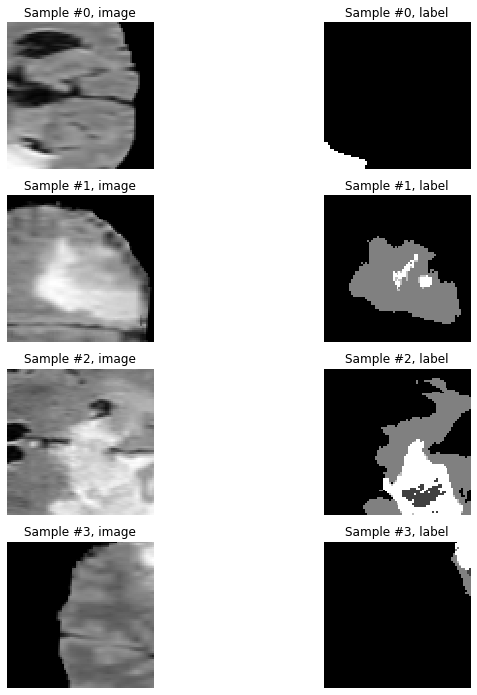

In [0]:
fig = plt.figure(figsize=(10, 10))

# sample = tf[3]
# # 4 are 4 modalities, which are FLAIR, T1, T1c, T2, and 75*75*75 is 3D image patch.
# print(sample['images'].shape, sample['labels'].shape)# (4, 75, 75, 75), (75, 75, 75)

# np.savetxt('1.txt', sample['labels'][:, :, 38])
for i in range(len(tf)):
    sample = tf[i]

    print(i, sample['images'].shape, sample['labels'].shape)

    ax1 = plt.subplot(4, 2, 2*i+1)
    plt.tight_layout()
    ax1.set_title('Sample #{}, image'.format(i))
    ax1.axis('off')
    show_image(sample['images'])
    ax2 = plt.subplot(4, 2, 2*i+2)
    plt.tight_layout()
    ax2.set_title('Sample #{}, label'.format(i))
    ax2.axis('off')
    show_label(sample['labels'])

    if i == 3:
        plt.show()
        break


# Define a Loss function and Optimizer

In [0]:
!cd HGG&&cd brats_2013_pat0001_1&&cd VSD.Brain.XX.O.MR_Flair.54512&&ls

VSD.Brain.XX.O.MR_Flair.54512.nii  VSD.Brain.XX.O.MR_Flair.54512.nii.gz


In [0]:
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.9, eps=10**(-4), weight_decay=1e-4, momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [0]:
import os
ckpt = 'drive/Single_Pathway_DeepMedic/saved_models' # the directory of checkpoints.
if not os.path.exists(ckpt):
    os.mkdir(ckpt)

particular_epoch = 100
save_epochs_steps = 100

start_epoch = 0
num_epochs = 400

num_classes = 5
crop_size = [75,75,75]
center_size = [47,47,47]
running_lr = 1e-3

for epoch in range(start_epoch + 1, num_epochs + 1):
    losses = AverageMeter()

    model.train()
    for iteration, sample in enumerate(train_loader):
        image = sample['images'].float()
        target = sample['labels'].long()
        image = Variable(image).cuda()
        label = Variable(target).cuda()       
        
        print(image.shape)
        print(target.shape)
        # The dimension of out should be in the dimension of B,C,W,H,D
        # transform the prediction and label
        out = model(image) 
        print(out.shape)
        out = out.permute(0,2,3,4,1).contiguous().view(-1, num_classes)# the size -1 is inferred from other dimensions
        print(out.shape)
        # extract the center part of the labels
        start_index = []
        end_index = []
        for i in range(3):
            start = int((crop_size[i] - center_size[i])/2)
            start_index.append(start)
            end_index.append(start + center_size[i])
        label = label[:, start_index[0]:end_index[0], start_index[1]: end_index[1], start_index[2]: end_index[2]]
        label = label.contiguous().view(-1).cuda()       
        print(label.shape)
        loss = criterion(out, label)
        # losses.update(loss.data[0],image.size(0))
        losses.update(loss.item(),image.size(0)) # changed by hjy

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # adjust learning rate
#         cur_iter = iteration + (epoch - 1) * args.epoch_iters
#         adjust_learning_rate(optimizer, cur_iter, args)

        print('   * i {} |  lr: {:.6f} | Training Loss: {losses.avg:.3f}'.format(iteration, running_lr, losses=losses))
      
    print('   * EPOCH {epoch} | Training Loss: {losses.avg:.3f}'.format(epoch=epoch, losses=losses))
    if epoch > particular_epoch:
        if epoch % save_epochs_steps == 0:
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'opt_dict': optimizer.state_dict()},\
                      ckpt + '/' + str(epoch) + '_checkpoint.pth.tar')

torch.Size([10, 4, 75, 75, 75])
torch.Size([10, 75, 75, 75])
torch.Size([10, 5, 47, 47, 47])
torch.Size([1038230, 5])
torch.Size([1038230])
   * i 0 |  lr: 0.001000 | Training Loss: 1.538
torch.Size([10, 4, 75, 75, 75])
torch.Size([10, 75, 75, 75])
torch.Size([10, 5, 47, 47, 47])
torch.Size([1038230, 5])
torch.Size([1038230])
   * i 1 |  lr: 0.001000 | Training Loss: 1.475
   * EPOCH 1 | Training Loss: 1.475
torch.Size([10, 4, 75, 75, 75])
torch.Size([10, 75, 75, 75])
torch.Size([10, 5, 47, 47, 47])
torch.Size([1038230, 5])
torch.Size([1038230])
   * i 0 |  lr: 0.001000 | Training Loss: 1.237
torch.Size([10, 4, 75, 75, 75])
torch.Size([10, 75, 75, 75])
torch.Size([10, 5, 47, 47, 47])
torch.Size([1038230, 5])
torch.Size([1038230])
   * i 1 |  lr: 0.001000 | Training Loss: 1.138
   * EPOCH 2 | Training Loss: 1.138
torch.Size([10, 4, 75, 75, 75])
torch.Size([10, 75, 75, 75])
torch.Size([10, 5, 47, 47, 47])
torch.Size([1038230, 5])
torch.Size([1038230])
   * i 0 |  lr: 0.001000 | Training 

# Testing

In [0]:
# Loading the checkpoints for testing 
test_path = 'drive/Single_Pathway_DeepMedic/datalist/test_list.txt'
ckpt_path = 'drive/Single_Pathway_DeepMedic/saved_models/400_checkpoint.pth.tar'

if os.path.isfile(ckpt_path):
    print("=> Loading checkpoint '{}'".format(ckpt_path))
    checkpoint = torch.load(ckpt_path)
    state_dict = checkpoint['state_dict']
    model.load_state_dict(state_dict)           
    print("=> Loaded checkpoint (epoch {})".format(checkpoint['epoch']))
else:
    raise Exception("=> No checkpoint found at '{}'".format(ckpt_path)) 


=> Loading checkpoint 'drive/Single_Pathway_DeepMedic/saved_models/400_checkpoint.pth.tar'
=> Loaded checkpoint (epoch 400)


E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [0]:

test_file = open(test_path, 'r')
test_dir = test_file.readlines()
root_path = './'

tf = ValDataset_full(test_dir)   
sample = tf[0]
print(sample['images'].shape)
test_loader = DataLoader(tf, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

(4, 240, 240, 155)


In [0]:
!nvidia-smi

Wed Nov 13 23:44:58 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    527MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
result = './result' 
if not os.path.exists(result):
    os.mkdir(result)
    
# save prediction results in the format of online submission
def visualize_result(name, pred):
    _, name1, _, name2 = name.split("/")
    _, _, _, _, _, name3, _ = name2.split(".")
    pred = sitk.GetImageFromArray(pred)
    sitk.WriteImage(pred, result + "/VSD"+"."+ str(name1) + '.'+ str(name3)+ '.mha')
    
def accuracy(pred, mask, label):
    # columns in score is (# pred, # label, pred and label)
    score = np.zeros([3,3])

    # compute Enhance score (label==4) in the first line
    score[0,0] = np.count_nonzero(pred * mask == 4)
    score[0,1] = np.count_nonzero(label == 4)
    score[0,2] = np.count_nonzero(pred * mask * label == 16)
    
    # compute Core score (label == 1,3,4) in the second line
    pred[pred > 2] = 1
    label[label > 2] = 1
    score[1,0] = np.count_nonzero(pred * mask == 1)
    score[1,1] = np.count_nonzero(label == 1)
    score[1,2] = np.count_nonzero(pred * mask * label == 1)
    
    # compute Whole score (all labels) in the third line
    pred[pred > 1] = 1
    label[label > 1] = 1
    score[2,0] = np.count_nonzero(pred * mask == 1)
    score[2,1] = np.count_nonzero(label == 1)
    score[2,2] = np.count_nonzero(pred * mask * label == 1)
    return score

In [35]:
num_inputs = 5
# switch to evaluate mode
model.eval()

# initialization      
num_ignore = 0
num_images = int(len(test_dir)/num_inputs)
# columns in score is (# pred, # label, pred and label)
# lines in score is (Enhance, Core, Whole)
dice_score = np.zeros([num_images, 3]).astype(float)

for i, sample in enumerate(test_loader):
    image = sample['images'].float().cuda()
    label = sample['labels'].long().cuda()
    mask = sample['mask'].long().cuda()
    name = sample['name'][0]

    with torch.no_grad():      
        image = Variable(image)
        label = Variable(label)
        mask = Variable(mask)

        # The dimension of out should be in the dimension of B,C,H,W,D
        out = model(image)
        out = out.permute(0,2,3,4,1)
        out = torch.max(out, 4)[1]
#         print(out.shape)
        # start index corresponding to the model
        start = [14, 14, 14]
        center = out.size()[1:]
        prediction = torch.zeros(label.size())
        prediction[:, start[0]:start[0]+center[0], start[1]: start[1]+center[1], start[2]: start[2]+center[2]] = out
        
        out = prediction
        # make the prediction corresponding to the center part of the image
        prediction = prediction.contiguous().view(-1).cuda()            
        label = label.contiguous().view(-1)                  
        mask = mask.contiguous().view(-1)

    # compute the dice score
    score_per_image = accuracy(prediction.data.cpu().numpy(), mask.data.cpu().numpy(), label.data.cpu().numpy()) 

    if np.sum(score_per_image[0,:]) == 0 or np.sum(score_per_image[1,:]) == 0 or np.sum(score_per_image[2,:]) == 0:
        num_ignore += 1
        continue 
    # compute the Enhance, Core and Whole dice score
    dice_score_per = [2 * np.sum(score_per_image[k,2]) / (np.sum(score_per_image[k,0]) + np.sum(score_per_image[k,1])) for k in range(3)]   
    print('Image: %d, Enhance score: %.4f, Core score: %.4f, Whole score: %.4f' % (i, dice_score_per[0], dice_score_per[1], dice_score_per[2]))           

    dice_score[i, :] = dice_score_per

    # save the result
    vis = out.data.cpu().numpy()[0]
#     print(vis.shape)
    vis = np.swapaxes(vis, 0, 2).astype(dtype=np.uint8)
    visualize_result(name, vis)

count_image = num_images - num_ignore
dice_score = dice_score[:count_image,:]
mean_dice = np.mean(dice_score, axis=0)
std_dice = np.std(dice_score, axis=0)
print('Evalution Done!')
print('Enhance score: %.4f, Core score: %.4f, Whole score: %.4f, Mean Dice score: %.4f' % (mean_dice[0], mean_dice[1], mean_dice[2], np.mean(mean_dice)))
print('Enhance std: %.4f, Core std: %.4f, Whole std: %.4f, Mean Std: %.4f' % (std_dice[0], std_dice[1], std_dice[2], np.mean(std_dice)))                         


Image: 0, Enhance score: 0.8633, Core score: 0.7707, Whole score: 0.7987
Image: 1, Enhance score: 0.8060, Core score: 0.3313, Whole score: 0.9285
Image: 2, Enhance score: 0.8821, Core score: 0.7975, Whole score: 0.7959
Image: 3, Enhance score: 0.7354, Core score: 0.7211, Whole score: 0.6365
Image: 4, Enhance score: 0.8656, Core score: 0.7125, Whole score: 0.9237
Image: 5, Enhance score: 0.9040, Core score: 0.8984, Whole score: 0.8513
Image: 6, Enhance score: 0.8873, Core score: 0.6755, Whole score: 0.9403
Image: 7, Enhance score: 0.7028, Core score: 0.6419, Whole score: 0.6260
Image: 8, Enhance score: 0.9293, Core score: 0.8726, Whole score: 0.8910
Image: 9, Enhance score: 0.6380, Core score: 0.6580, Whole score: 0.6499
Image: 10, Enhance score: 0.6257, Core score: 0.8877, Whole score: 0.9218
Image: 11, Enhance score: 0.6383, Core score: 0.4929, Whole score: 0.7111
Image: 12, Enhance score: 0.8661, Core score: 0.5126, Whole score: 0.8950
Image: 13, Enhance score: 0.9479, Core score: 0.